In [2]:
!unzip -d . fer2013.zip >/dev/null2>&1

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import os
from shutil import copyfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import torchvision
import time

In [41]:
data_transforms = {
    'Training': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomCrop(42), # 随机裁剪一个size大小
        transforms.RandomHorizontalFlip(), # 随机水平翻转
        transforms.ToTensor(),
    ]),
    'PublicTest': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(42),
        transforms.ToTensor(),
    ]),
}

data_dir = 'fer2013'

image_datasets = {x :datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'PublicTest']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
               for x in ['Training', 'PublicTest']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'PublicTest']}
class_names = image_datasets['Training'].classes
device = torch.device('cuda:0')

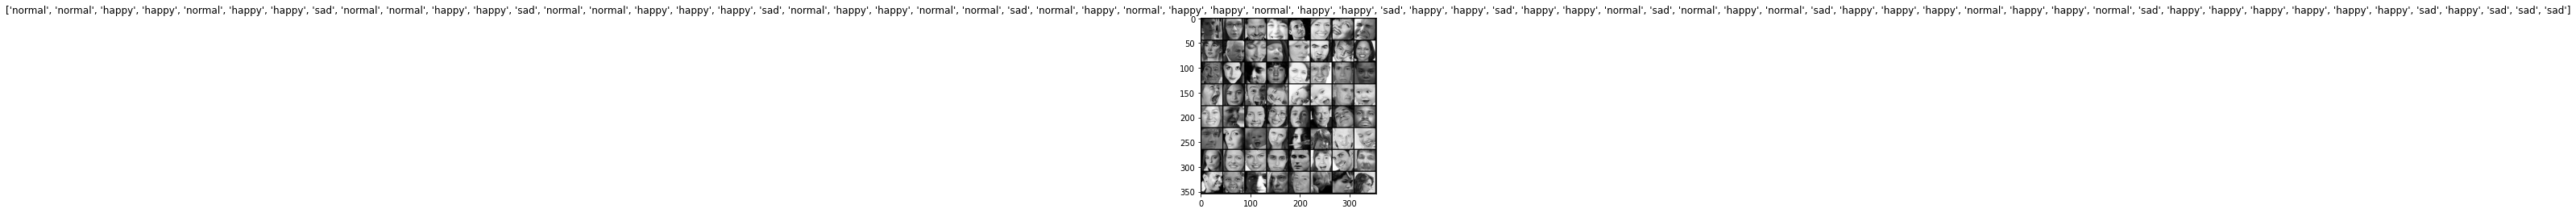

In [33]:
def imshow(inp, title=None):
    '''Imshow for Tensor'''
    inp = inp.numpy().transpose(1, 2, 0)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 获取一批训练数据
inputs, classes = next(iter(dataloaders['Training']))

# 批量制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 4, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(5 * 5 * 64, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 5 * 5 * 64)
        x = nn.Dropout(0.4)(F.relu(self.fc1(x)))
        x = nn.Dropout(0.4)(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [70]:
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1600, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=3, bias=True)
)


In [71]:
import copy
loss_list = {'Training': [], 'PublicTest': []}
def train_model(model, criterion, optimizer, scheduler, num_epoches=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epoches):
        print('Epoch {}/{}'.format(epoch, num_epoches - 1))
        print('-' * 10)
        
        # 每个epoch都有一个训练和验证阶段
        for phase in ['Training', 'PublicTest']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode，此时训练不会BN和dropout，权重不会改变
            
            running_loss = 0.0
            running_corrects = 0
            
            #  迭代数据
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)
              
              # 零参数梯度
              optimizer.zero_grad()
              
              # 前向
              # track history if only in train
              with torch.set_grad_enabled(phase == 'Training'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                  
                  # 向后+仅在训练阶段进行优化
                  if phase == 'Training':
                      loss.backward()
                      optimizer.step()
                      
              # 统计
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_list[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 深度复制model
            if phase == 'PublicTest' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
     # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [72]:
criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 每7个epochs衰减LR通过设置gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [73]:
def plotLoss(n_epochs, loss):
    plt.plot(range(n_epochs), loss['Training'], marker='o', label='Training Loss')
    plt.plot(range(n_epochs), loss['PublicTest'], marker='v', label='Test Loss')
    plt.title('Learning Curve')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 0/49
----------
Training Loss: 1.0256 Acc: 0.4736
PublicTest Loss: 0.9649 Acc: 0.5174

Epoch 1/49
----------
Training Loss: 0.8819 Acc: 0.5788
PublicTest Loss: 0.8803 Acc: 0.5768

Epoch 2/49
----------
Training Loss: 0.8302 Acc: 0.6071
PublicTest Loss: 0.8514 Acc: 0.5921

Epoch 3/49
----------
Training Loss: 0.8013 Acc: 0.6251
PublicTest Loss: 0.8530 Acc: 0.5865

Epoch 4/49
----------
Training Loss: 0.7671 Acc: 0.6455
PublicTest Loss: 0.8148 Acc: 0.6093

Epoch 5/49
----------
Training Loss: 0.7486 Acc: 0.6541
PublicTest Loss: 0.7997 Acc: 0.6190

Epoch 6/49
----------
Training Loss: 0.7274 Acc: 0.6700
PublicTest Loss: 0.8199 Acc: 0.6195

Epoch 7/49
----------
Training Loss: 0.7144 Acc: 0.6757
PublicTest Loss: 0.7528 Acc: 0.6473

Epoch 8/49
----------
Training Loss: 0.7076 Acc: 0.6781
PublicTest Loss: 0.7692 Acc: 0.6408

Epoch 9/49
----------
Training Loss: 0.6900 Acc: 0.6915
PublicTest Loss: 0.7761 Acc: 0.6427

Epoch 10/49
----------
Training Loss: 0.6776 Acc: 0.6959
PublicTest Lo

ValueError: ignored

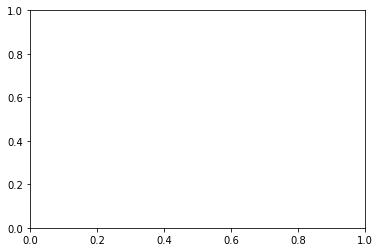

In [74]:
model = train_model(net, criterion, optimizer, exp_lr_scheduler, num_epoches=50)
torch.save(model, 'FERmodel.pt')
plotLoss(50, loss_list)

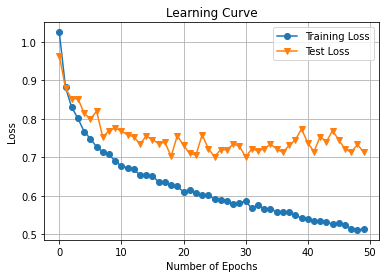

In [75]:
plotLoss(50, loss_list)